In [1]:
import pandas
import konlpy
import gensim
import numpy as np
import tensorflow as tf

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('data/ratings_train.txt')
test_data = pd.read_table('data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
print(get_decoded_sentence(X_train[0], index_to_word))

더 빙 . . 진짜 짜증 나 네요 목소리


In [7]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[0])     # '<BOS>' 가 출력됩니다.  
print(index_to_word[98])     # 'the' 가 출력됩니다.

# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(X_train[0], index_to_word))

<PAD>
시간
드라마 귀신 <UNK> <UNK> 같 씨 없 음 달


In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## LSTM 모델, Conv1D + LSTM 모델

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

vocab_size = len(word_to_index) # 어휘 사전의 크기입니다
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다.
dropout_ratio = 0.2 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수

from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim))
model.add(LSTM(64, return_sequences=True))  # LSTM 추가
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(LSTM(64))  # Conv1D 뒤에 LSTM 추가
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         77056     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,167,681
Trainable params: 1,167,681
Non-trainable params: 0
____________________________________________

In [11]:
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    callbacks=[es, mc],
                    verbose=1)

Epoch 1/30
532/532 [==============================] - 56s 10ms/step - loss: 0.3765 - accuracy: 0.8304 - val_loss: 0.3202 - val_accuracy: 0.8588
Epoch 2/30
532/532 [==============================] - 4s 8ms/step - loss: 0.2898 - accuracy: 0.8769 - val_loss: 0.3119 - val_accuracy: 0.8633
Epoch 3/30
532/532 [==============================] - 4s 8ms/step - loss: 0.2479 - accuracy: 0.8972 - val_loss: 0.3167 - val_accuracy: 0.8647
Epoch 4/30
532/532 [==============================] - 4s 8ms/step - loss: 0.2061 - accuracy: 0.9179 - val_loss: 0.3553 - val_accuracy: 0.8540
Epoch 5/30
532/532 [==============================] - 4s 8ms/step - loss: 0.1679 - accuracy: 0.9357 - val_loss: 0.3945 - val_accuracy: 0.8600
Epoch 00005: early stopping


In [13]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3964 - accuracy: 0.8575
[0.3963925540447235, 0.857538104057312]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


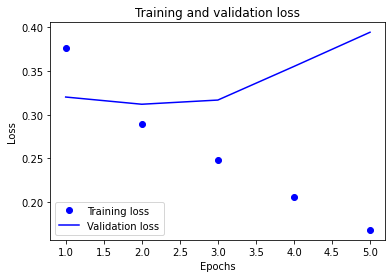

In [14]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

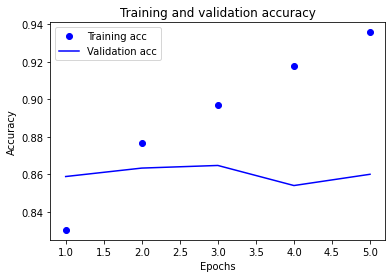

In [15]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## GRU 모델

In [16]:
from tensorflow.keras.layers import GRU

gru_model = Sequential([
    Embedding(vocab_size, word_vector_dim),
    GRU(64, return_sequences=True),
    GlobalMaxPooling1D(),
    Dense(hidden_units, activation='relu'),
    Dropout(dropout_ratio),
    Dense(1, activation='sigmoid')
])

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

gru_model.summary()

# GRU 모델 학습
gru_history = gru_model.fit(partial_x_train, partial_y_train, epochs=30, batch_size=256,
                            validation_data=(x_val, y_val), callbacks=[es, mc], verbose=1)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
gru (GRU)                    (None, None, 64)          31872     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,040,321
Trainable params: 1,040,321
Non-trainable params: 0
____________________________________________

In [17]:
results = gru_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3800 - accuracy: 0.8538
[0.37998032569885254, 0.8537746667861938]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


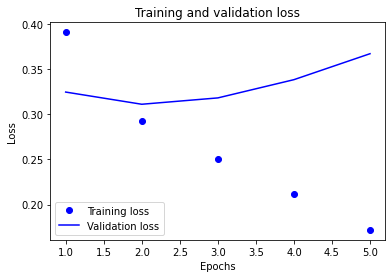

In [18]:
history_dict = gru_history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

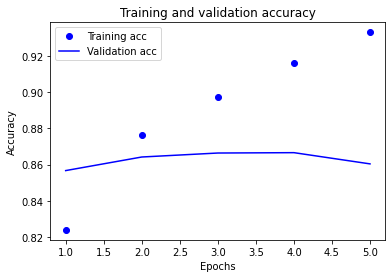

In [19]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## CNN 모델

In [20]:
cnn_model = Sequential([
    Embedding(vocab_size, word_vector_dim),
    Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(hidden_units, activation='relu'),
    Dropout(dropout_ratio),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.summary()

# CNN 모델 학습
cnn_history = cnn_model.fit(partial_x_train, partial_y_train, epochs=30, batch_size=256,
                            validation_data=(x_val, y_val), callbacks=[es, mc], verbose=1)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 1,080,769
Trainable params: 1,080,769
Non-trainable params: 0
____________________________________________

In [21]:
results = cnn_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5404 - accuracy: 0.8481
[0.5403572916984558, 0.8480786085128784]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


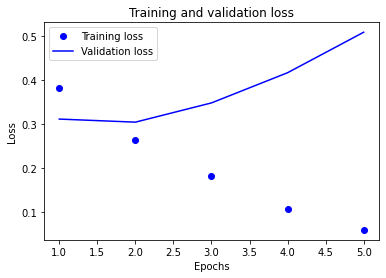

In [22]:
history_dict = cnn_history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

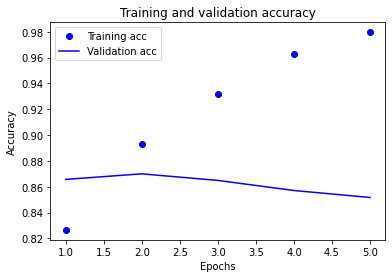

In [23]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 2. gensim을 활용한 비교

In [36]:
from gensim.models import Word2Vec
from konlpy.tag import Mecab

# Mecab 형태소 분석기 초기화
tokenizer = Mecab()

# Word2Vec 학습 데이터 준비 (토큰화 적용)
train_corpus = [tokenizer.morphs(sentence) for sentence in train_data['document'].dropna()]
test_corpus = [tokenizer.morphs(sentence) for sentence in test_data['document'].dropna()]

# 전체 학습용 말뭉치 데이터 생성
word2vec_corpus = train_corpus + test_corpus  

# Word2Vec 모델 학습
word2vec_model = Word2Vec(sentences=word2vec_corpus, vector_size=100, window=5, min_count=5, workers=4, sg=0)  # CBOW 방식 사용

# 모델 저장
word2vec_model.save("word2vec_model")

# 유사 단어 비교
print("자체 학습된 Word2Vec 유사 단어:")
print(word2vec_model.wv.most_similar("영화", topn=5))

# 사전 학습된 Word2Vec 모델 로드
from gensim.models import KeyedVectors

pretrained_w2v_path = "../../data/word2vec_ko.model"  # 사전 학습된 Word2Vec 모델 경로
pretrained_w2v = KeyedVectors.load(pretrained_w2v_path)

print("사전 학습된 Word2Vec 유사 단어:")
print(pretrained_w2v.wv.most_similar("영화", topn=5))


자체 학습된 Word2Vec 유사 단어:
[('드라마', 0.6874570250511169), ('작품', 0.6185590028762817), ('애니메이션', 0.6056032180786133), ('애니', 0.5887455344200134), ('수작', 0.5404873490333557)]
사전 학습된 Word2Vec 유사 단어:
[('드라마', 0.8418774008750916), ('뮤지컬', 0.7775140404701233), ('코미디', 0.7489107251167297), ('다큐멘터리', 0.7401294708251953), ('헐리우드', 0.7397844195365906)]


# 3. Word2Vec을 적용하여 성능 향상

In [53]:
import numpy as np
from keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Attention
from keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras import regularizers

# Word2Vec을 활용한 임베딩 매트릭스 생성
embedding_dim = 100  # Word2Vec의 벡터 차원과 동일하게 설정

vocab_size = max(word_to_index.values()) + 1  # ✅ word_to_index 내 가장 큰 인덱스 사용
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_to_index.items():
    if word in w2v_model.wv.key_to_index:
        embedding_matrix[i] = w2v_model.wv[word]


# Word2Vec 기반 Embedding Layer
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False)  # 학습하지 않고 고정된 사전 학습 벡터 사용

# 모델 구성
model = Sequential([
    embedding_layer,  # Word2Vec 사전 학습된 임베딩 적용
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),  
    GlobalMaxPooling1D(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# 모델 학습 설정
model.compile(optimizer=Adam(learning_rate=0.0005, clipnorm=1.0),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 학습
history = model.fit(partial_x_train, partial_y_train, epochs=30, batch_size=256,
                    validation_data=(x_val, y_val), callbacks=[es, mc], verbose=1)

# 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)
print(f"Word2Vec 기반 모델 정확도: {results[1]:.4f}")


Epoch 1/30
532/532 [==============================] - 162s 295ms/step - loss: 0.8440 - accuracy: 0.7310 - val_loss: 0.4562 - val_accuracy: 0.7943
Epoch 2/30
532/532 [==============================] - 155s 291ms/step - loss: 0.4566 - accuracy: 0.7887 - val_loss: 0.4160 - val_accuracy: 0.8138
Epoch 3/30
532/532 [==============================] - 157s 294ms/step - loss: 0.4297 - accuracy: 0.8029 - val_loss: 0.3975 - val_accuracy: 0.8197
Epoch 4/30
532/532 [==============================] - 157s 294ms/step - loss: 0.4118 - accuracy: 0.8140 - val_loss: 0.3918 - val_accuracy: 0.8252
Epoch 5/30
532/532 [==============================] - 156s 293ms/step - loss: 0.4007 - accuracy: 0.8191 - val_loss: 0.3836 - val_accuracy: 0.8292
Epoch 6/30
532/532 [==============================] - 156s 294ms/step - loss: 0.3902 - accuracy: 0.8250 - val_loss: 0.3777 - val_accuracy: 0.8285
Epoch 7/30
532/532 [==============================] - 156s 294ms/step - loss: 0.3816 - accuracy: 0.8289 - val_loss: 0.3761 -

아무리 해도 안되네요 실패,,!

# 회고

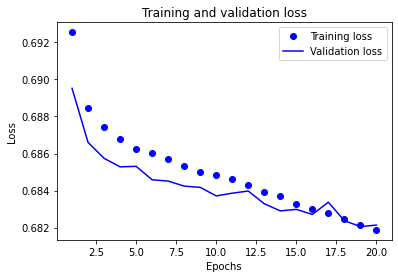

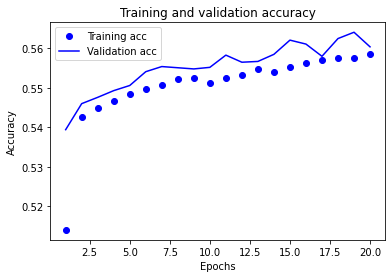
처음 모델 1개로만 돌렸을 때의 참혹한 결과,,
이진분류인데 정확도가 55면,, 그냥 찍는게,,

시간이 부족해서 아직 워드투벡터는 시작도 못해봤다.
아직 개념이 머리에 확실하지 않아서 내가 원하는대로 코드를 짜고 모델을 사용하는 것에 어려움을 느끼는 것 같다.